TO DISCUSS:
* predicting embeddings (currently on train set)
* selecting source nodes (both in dataset and negative sampling for scoring) because evaluation size not same.

In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
y = snakemake_utils.get_dataset("airport").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/airport/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['airport_one/', 'airport_two/', 'airport_three/', 'airport_four/', 'airport_five/']
DATASET = 'airport'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk", 
    "word2vec_baseline", "word2vec_r2v", "word2vec_baseline_crosswalk", "word2vec_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/airport/airport_one/airport_test_adj.npz'
NUM_NODES=2898
k=5

airport_five  airport_one    airport_two     roc_score.pkl
airport_four  airport_three  gini_score.pkl  sp_score.pkl


# distributions of positive and negative edgeswith dot product

In [4]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [5]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [6]:
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec baseline

In [7]:
model = "word2vec_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_word2vec_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10376


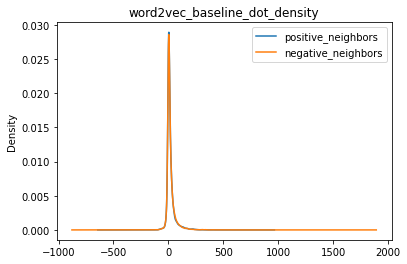

In [8]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.81it/s]


((14486, 2), 0.0009350561353879904, 0.4979392516774075, 0.175835914614111)

# word2vec crosswalk

In [10]:
model = "word2vec_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_word2vec_node2vec_embs.npy')
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 10350


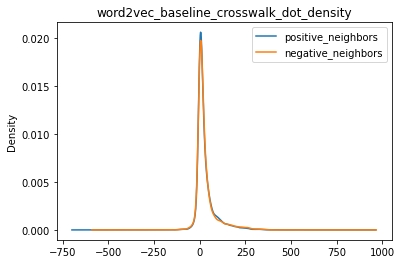

In [11]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 241.08it/s]


((14486, 2), 0.0008899648952674606, 0.50035660108754, 0.17217091116645855)

# word2vec r2v

In [13]:
model = "word2vec_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_word2vec_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10379


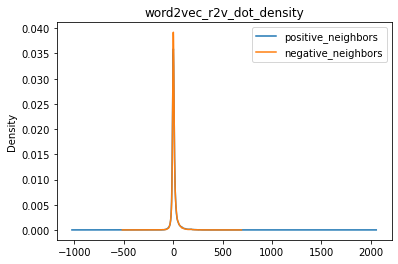

In [14]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 238.08it/s]


((14490, 2), 0.0009004741489398304, 0.4962117275631261, 0.16996493967385917)

# word2vec r2v crosswalk

In [16]:
model = "word2vec_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_word2vec_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(2898, 128)

selected edge_idx size: 10385


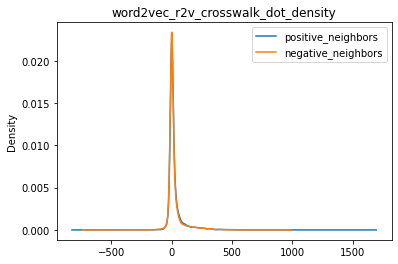

In [17]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 264.21it/s]


((14490, 2), 0.0009160177555528112, 0.5276987034325322, 0.17208341267743127)

# GCN ( baseline)

In [19]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10371


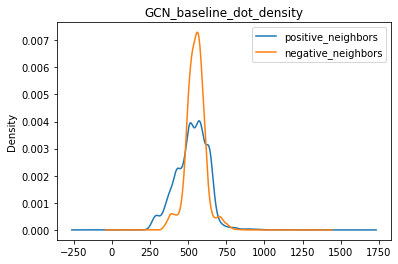

In [20]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 240.09it/s]


((14490, 2), 0.0080816489256664, 0.4421677349729156, 0.7509893159304735)

# GCN ( baseline + crosswalk)

In [22]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 10399


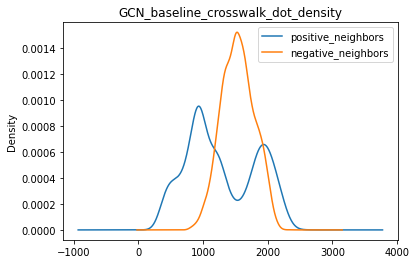

In [23]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 230.05it/s]


((14490, 2), 0.007872902059967577, 0.34568476236475987, 0.7385082708209766)

# GCN ( r2v)

In [25]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10378


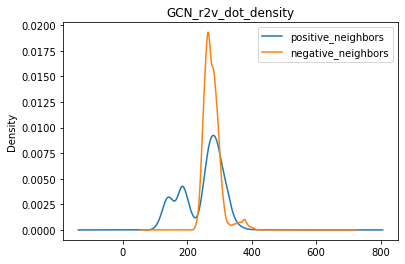

In [26]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.77it/s]


((14490, 2), 0.008080670977465412, 0.4270805830974777, 0.7490488933827727)

# GCN ( r2v + crosswalk)

In [28]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(2898, 128)

selected edge_idx size: 10361


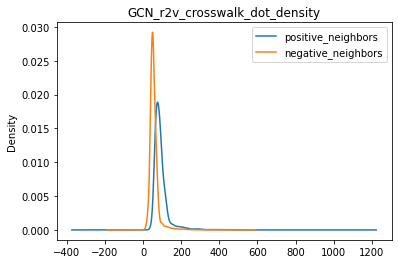

In [29]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 232.80it/s]


((14490, 2), 0.0077163752969860505, 0.887803279135048, 0.7389070971865016)

# GAT ( baseline)

In [31]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(2898, 128)

selected edge_idx size: 10380


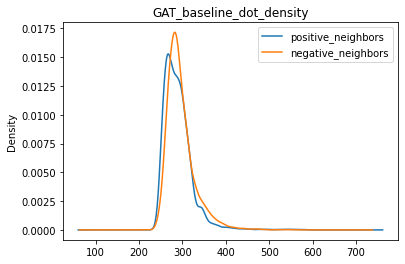

In [32]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [33]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.40it/s]


((14490, 2), 0.008037776776674787, 0.42870507423123616, 0.7515010771296705)

# GAT ( baseline + crosswalk)

In [34]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10371


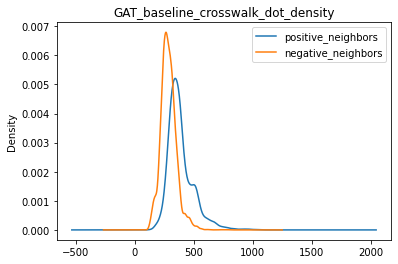

In [35]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [36]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.93it/s]


((14484, 2), 0.007900250985380103, 0.8117647494704723, 0.7423403886934039)

# GAT ( r2v)

In [37]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10373


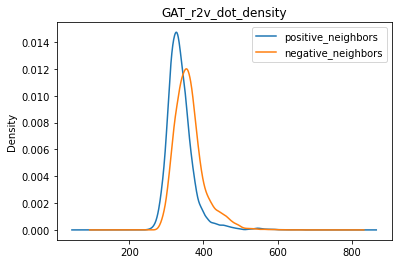

In [38]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [39]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.20it/s]


((14490, 2), 0.007934377402078202, 0.3005946544418589, 0.7453640899711282)

# GAT ( r2v + crosswalk)

In [40]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 10397


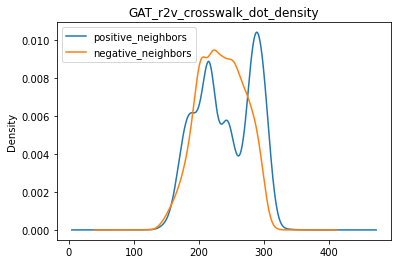

In [41]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [42]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.86it/s]


((14490, 2), 0.007663147258766673, 0.55500189648043, 0.7336203241106339)

# plot statistical parity scores

# gini sp scores

word2vec_baseline 0.175835914614111
word2vec_baseline_crosswalk 0.17217091116645855
word2vec_r2v 0.16996493967385917
word2vec_r2v_crosswalk 0.17208341267743127
GCN_baseline 0.7509893159304735
GCN_baseline_crosswalk 0.7385082708209766
GCN_r2v 0.7490488933827727
GCN_r2v_crosswalk 0.7389070971865016
GAT_baseline 0.7515010771296705
GAT_baseline_crosswalk 0.7423403886934039
GAT_r2v 0.7453640899711282
GAT_r2v_crosswalk 0.7336203241106339


Text(0.5, 1.0, 'gini statistical parity scores')

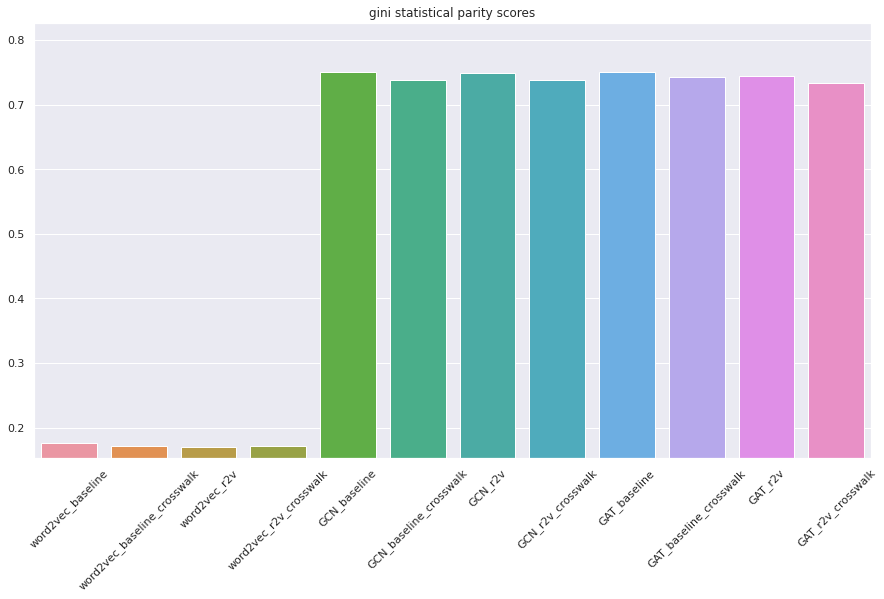

In [43]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec_baseline 0.0009350561353879904
word2vec_baseline_crosswalk 0.0008899648952674606
word2vec_r2v 0.0009004741489398304
word2vec_r2v_crosswalk 0.0009160177555528112
GCN_baseline 0.0080816489256664
GCN_baseline_crosswalk 0.007872902059967577
GCN_r2v 0.008080670977465412
GCN_r2v_crosswalk 0.0077163752969860505
GAT_baseline 0.008037776776674787
GAT_baseline_crosswalk 0.007900250985380103
GAT_r2v 0.007934377402078202
GAT_r2v_crosswalk 0.007663147258766673


Text(0.5, 1.0, 'statistical parity scores')

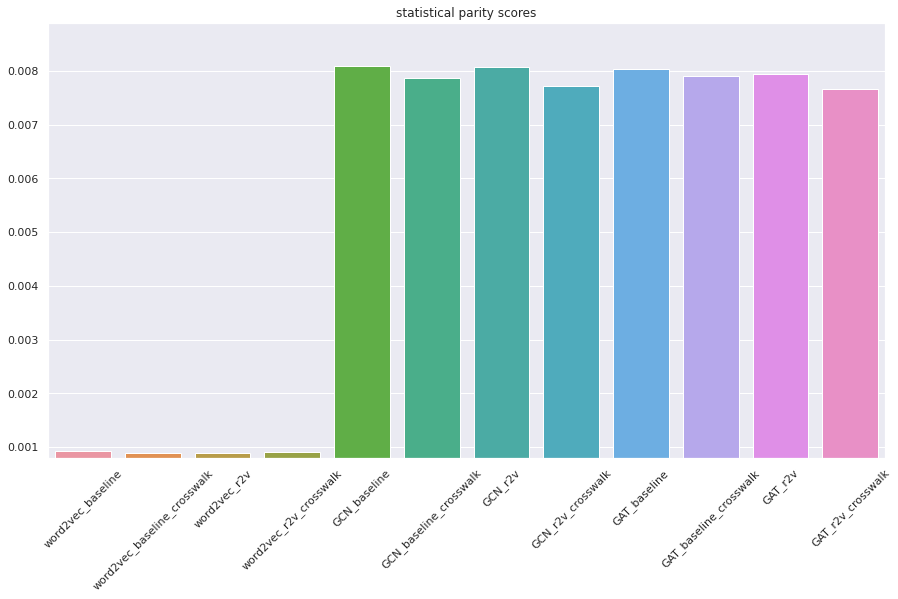

In [44]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec_baseline 0.4979392516774075
word2vec_baseline_crosswalk 0.50035660108754
word2vec_r2v 0.4962117275631261
word2vec_r2v_crosswalk 0.5276987034325322
GCN_baseline 0.4421677349729156
GCN_baseline_crosswalk 0.34568476236475987
GCN_r2v 0.4270805830974777
GCN_r2v_crosswalk 0.887803279135048
GAT_baseline 0.42870507423123616
GAT_baseline_crosswalk 0.8117647494704723
GAT_r2v 0.3005946544418589
GAT_r2v_crosswalk 0.55500189648043


Text(0.5, 1.0, 'roc scores')

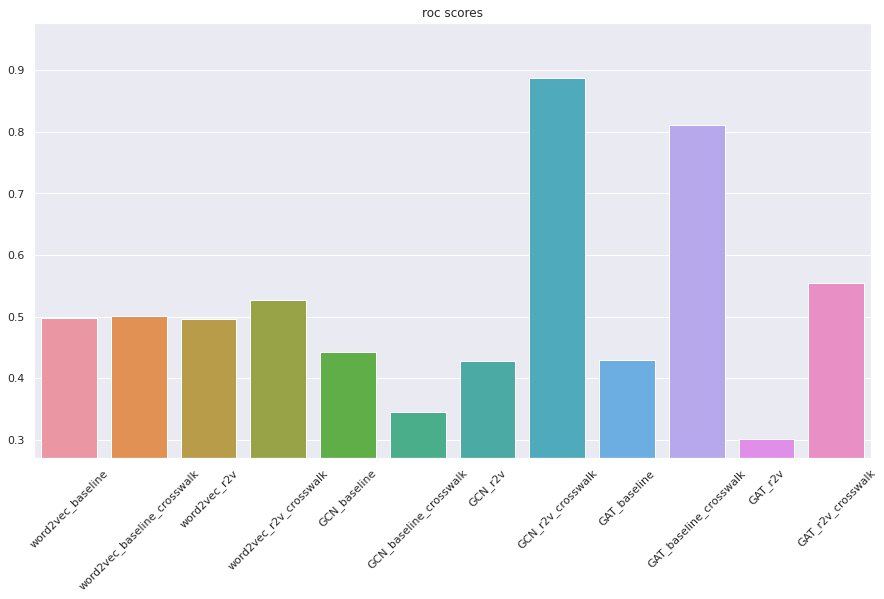

In [46]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [47]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 240.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 206.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.87it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

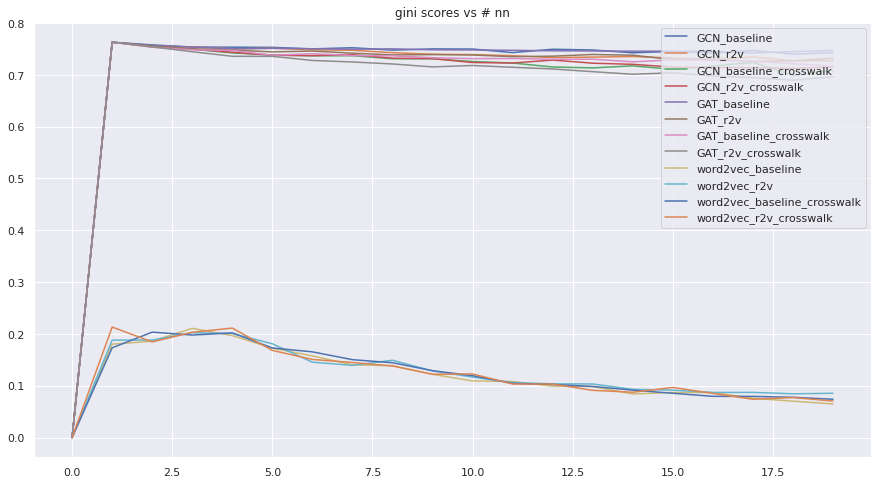

In [48]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

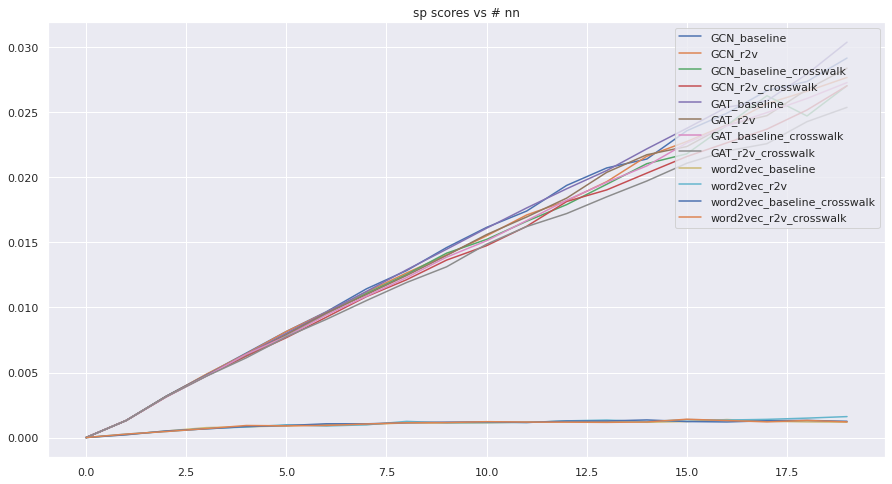

In [49]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [51]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy",
    "WORD2VEC_baseline": '_word2vec_node2vec_embs.npy',
    "WORD2VEC_baseline_crosswalk": "_crosswalk_word2vec_node2vec_embs.npy",
    "WORD2VEC_r2v": "_word2vec_r2v_node2vec_embs.npy",
    "WORD2VEC_r2v_crosswalk": "_crosswalk_word2vec_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 10382
selected edge_idx size: 10128
selected edge_idx size: 10429
selected edge_idx size: 10569
selected edge_idx size: 10426
selected edge_idx size: 10373
selected edge_idx size: 10061
selected edge_idx size: 10438
selected edge_idx size: 10549
selected edge_idx size: 10435
selected edge_idx size: 10363
selected edge_idx size: 10079
selected edge_idx size: 10410
selected edge_idx size: 10546
selected edge_idx size: 10414
selected edge_idx size: 10380
selected edge_idx size: 10099
selected edge_idx size: 10419
selected edge_idx size: 10557
selected edge_idx size: 10421
selected edge_idx size: 10366
selected edge_idx size: 10129
selected edge_idx size: 10419
selected edge_idx size: 10567
selected edge_idx size: 10412
selected edge_idx size: 10353
selected edge_idx size: 10102
selected edge_idx size: 10405
selected edge_idx size: 10519
selected edge_idx size: 10439
selected edge_idx size: 10335
selected edge_idx size: 10124
selected edge_idx size: 10427
selected e

Text(0.5, 1.0, 'roc scores')

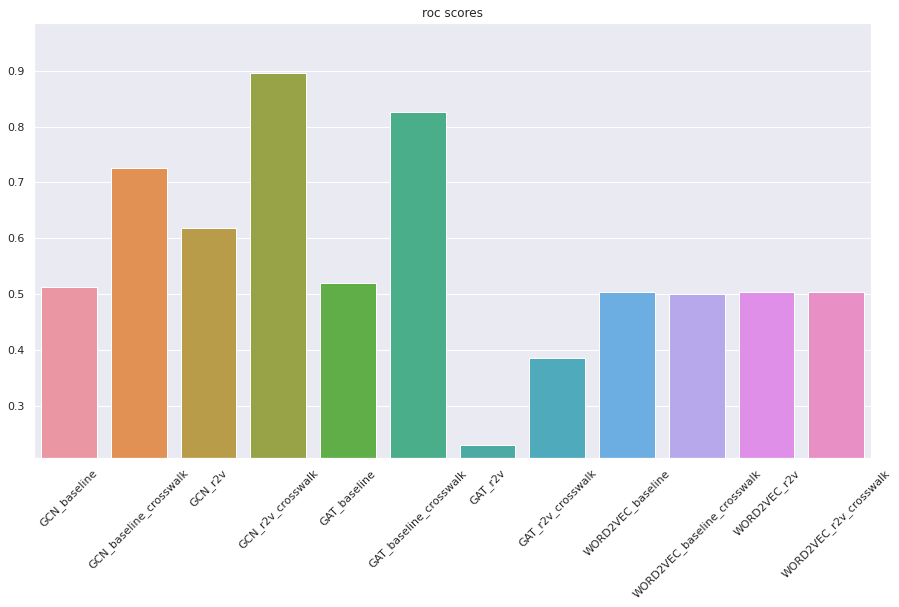

In [52]:

roc_score = {m: np.mean(roc_scores(m)) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 277.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 291.94it/s]


GCN_baseline 0.008017372456640321
GCN_baseline_crosswalk 0.007848240189829027
GCN_r2v 0.007869471875034895
GCN_r2v_crosswalk 0.0077487070365805846
GAT_baseline 0.007933923632022426
GAT_baseline_crosswalk 0.00781216406588332
GAT_r2v 0.007884682281076725
GAT_r2v_crosswalk 0.007735463982052511
WORD2VEC_baseline 0.0009182046766585669
WORD2VEC_baseline_crosswalk 0.0009101957386191699
WORD2VEC_r2v 0.0009236208593970563
WORD2VEC_r2v_crosswalk 0.0009219792822757339


Text(0.5, 1.0, 'statistical parity scores')

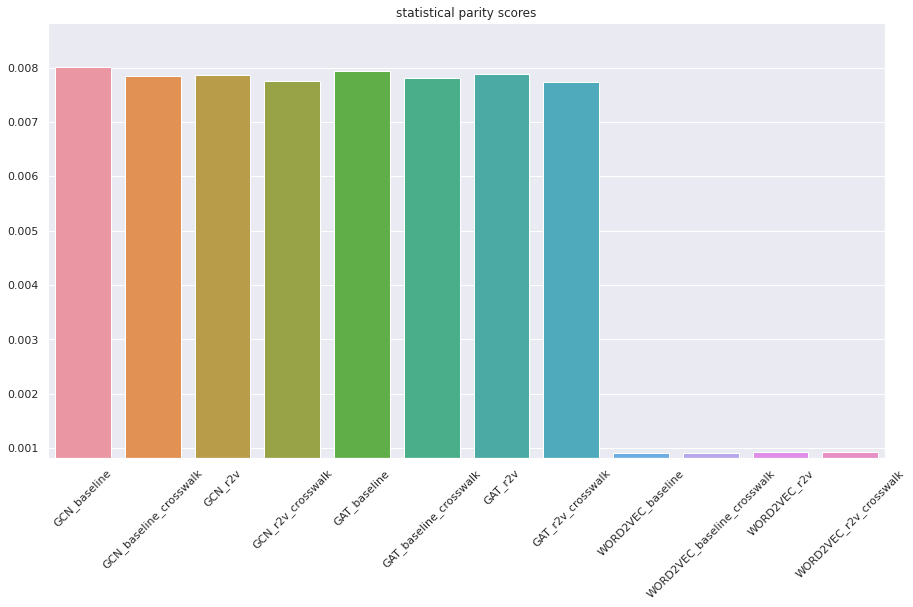

In [53]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.7486660061399201
GCN_baseline_crosswalk 0.7410619206417616
GCN_r2v 0.7464718485509114
GCN_r2v_crosswalk 0.7379870149039117
GAT_baseline 0.7483991754861595
GAT_baseline_crosswalk 0.740324224536655
GAT_r2v 0.7441846673712871
GAT_r2v_crosswalk 0.7344929606045097
WORD2VEC_baseline 0.1735873910953741
WORD2VEC_baseline_crosswalk 0.17154064942511088
WORD2VEC_r2v 0.17570884076091484
WORD2VEC_r2v_crosswalk 0.1759020030476751


Text(0.5, 1.0, 'gini statistical parity scores')

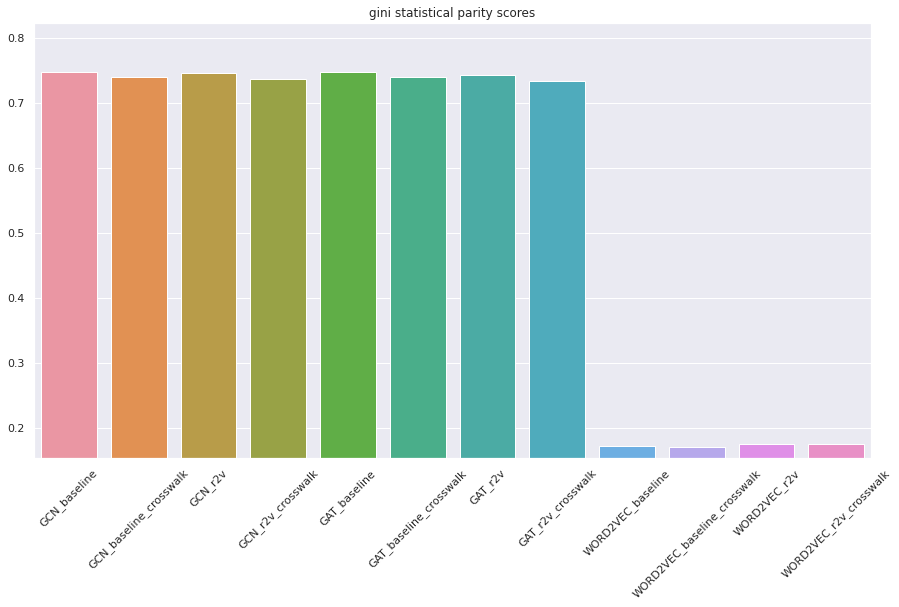

In [54]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [55]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}
temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 10392
selected edge_idx size: 10068
selected edge_idx size: 10442
selected edge_idx size: 10535
selected edge_idx size: 10441
selected edge_idx size: 10358
selected edge_idx size: 10114
selected edge_idx size: 10411
selected edge_idx size: 10528
selected edge_idx size: 10430
selected edge_idx size: 10364
selected edge_idx size: 10116
selected edge_idx size: 10423
selected edge_idx size: 10538
selected edge_idx size: 10418
selected edge_idx size: 10365
selected edge_idx size: 10087
selected edge_idx size: 10418
selected edge_idx size: 10501
selected edge_idx size: 10417
selected edge_idx size: 10365
selected edge_idx size: 10114
selected edge_idx size: 10427
selected edge_idx size: 10550
selected edge_idx size: 10423
selected edge_idx size: 10377
selected edge_idx size: 10134
selected edge_idx size: 10444
selected edge_idx size: 10530
selected edge_idx size: 10410
selected edge_idx size: 10374
selected edge_idx size: 10111
selected edge_idx size: 10412
selected e

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 257.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 260.87it/s]
